<a href="https://colab.research.google.com/github/Kryptera-K/ALB-AO-QQE-Momentum-Convergence-Strategy/blob/main/ALB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "ALB"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("ALB_clean.csv", index=False)
df

/tmp/ipython-input-3103918154.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,5.912294,6.343399,5.912294,6.343399,134000
2000-01-04,5.912294,6.097053,5.830179,5.830179,68200
2000-01-05,6.014940,6.076527,5.912296,5.912296,70000
2000-01-06,6.220228,6.240757,5.932825,5.973883,78600
2000-01-07,6.117585,6.220229,6.076528,6.199700,71800
...,...,...,...,...,...
2025-11-06,91.260002,97.099998,91.000000,94.000000,3772800
2025-11-07,97.180000,98.419998,90.010002,90.169998,4482800
2025-11-10,103.580002,104.599998,100.000000,101.419998,3390200


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

AO_CHANGE_SHIFT_1 = 5
AO_CHANGE_SHIFT_2 = 10
AO_LEVEL = 5
AO_LONG_PERIOD = 34
AO_SHORT_PERIOD = 5
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
BEAR_POWER_SHIFT = 5
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------

def ao_is_rising(df, short_period=AO_SHORT_PERIOD, long_period=AO_LONG_PERIOD, shift=AO_CHANGE_SHIFT_1):
    df = calculate_ao(df, short_period, long_period)
    return df['AO'] > df['AO'].shift(shift)


def calculate_ao(df, short_period=AO_SHORT_PERIOD, long_period=AO_LONG_PERIOD):
    """
    Calculate Awesome Oscillator (AO)
    df : pandas DataFrame with ['High', 'Low']
    short_period : short SMA (default 5)
    long_period : long SMA (default 34)
    """
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(window=short_period, min_periods=1).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(window=long_period, min_periods=1).mean()
    df['AO'] = df["SMA_short"] - df["SMA_long"]
    return df


def qqe_value1_lower_than_value2(df):
    df = calculate_qqe(df)
    return df['QQE_Value1'] < df['QQE_Value2']


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df


def bb_open_above_upper(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return df['Open'] > df['BB_Upper']


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df


def bears_power_change_up(df, period = BEAR_EMA_PERIOD, shifts=BEAR_POWER_SHIFT):
    df = calculate_bears_power(df, period)
    return df['Bears_Power'] > df['Bears_Power'].shift(shifts)


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    """Calculate Bears Power indicator and return updated DataFrame"""
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df



# -------------------------
# Entry conditions
# -------------------------

df["AO_Rising"] = ao_is_rising(df)
df["QQE_Value1_LowerThan_Value2"] = qqe_value1_lower_than_value2(df)

# -------------------------
# Exit conditions
# -------------------------

df["BB_Open_Above_Upper"] = bb_open_above_upper(df)
df["BearP_Upward"] = bears_power_change_up(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'AO_Rising',
    'QQE_Value1_LowerThan_Value2',
]
exit_conditions = [
    'BB_Open_Above_Upper',
    'BearP_Upward',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-1639013405.py:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2000-01-03 00:00:00
End                                  2025-11-12 00:00:00
Period                                6506 days 00:00:00
Start Value                                     100000.0
End Value                                 3115617.005898
Total Return [%]                             3015.617006
Benchmark Return [%]                         1561.727554
Max Gross Exposure [%]                             100.0
Total Fees Paid                            300148.882458
Max Drawdown [%]                               76.333928
Max Drawdown Duration                  772 days 00:00:00
Total Trades                                         113
Total Closed Trades                                  112
Total Open Trades                                      1
Open Trade PnL                             387308.653689
Win Rate [%]                                        75.0
Best Trade [%]                                 51.777083
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-11-12 00:00:00
Period                         6506 days 00:00:00
Start Value                              100000.0
End Value                          1661727.554224
Total Return [%]                      1561.727554
Benchmark Return [%]                  1561.727554
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        83.814412
Max Drawdown Duration           767 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1561727.554224
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-217768326.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-217768326.py:70: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



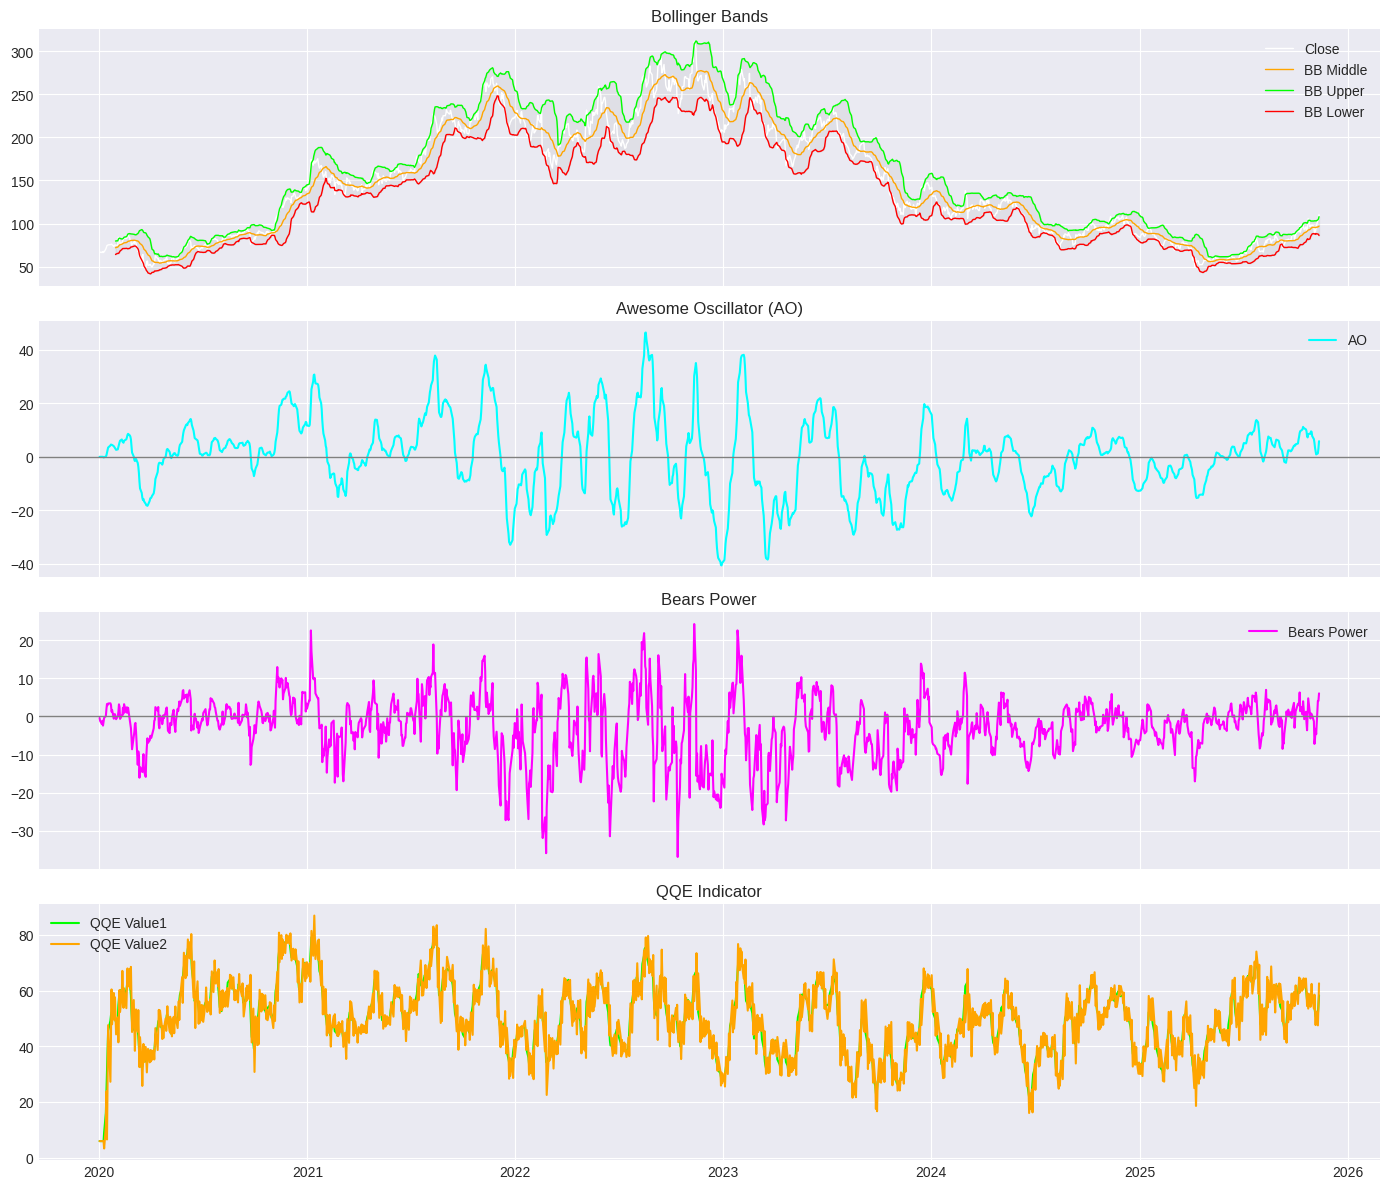

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "ALB"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------
AO_SHORT_PERIOD = 5
AO_LONG_PERIOD = 34
AO_CHANGE_SHIFT_1 = 5

BB_PERIOD = 20
BB_STD = 2

BEAR_EMA_PERIOD = 13
BEAR_POWER_SHIFT = 5

QQE_PERIOD = 14
QQE_SMOOTH = 5
QQE_FACTOR = 4.236

# -------------------------
# Indicator Functions
# -------------------------

def calculate_ao(df, short_period=AO_SHORT_PERIOD, long_period=AO_LONG_PERIOD):
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(window=short_period, min_periods=1).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(window=long_period, min_periods=1).mean()
    df['AO'] = df["SMA_short"] - df["SMA_long"]
    return df

def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df

def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df

def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    df = df.copy()

    # RSI
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # Smoothed RSI
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # RSI Delta
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # QQE lines
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2
    return df

# -------------------------
# Apply Indicators
# -------------------------
df = calculate_ao(df)
df = calculate_bollinger_bands(df)
df = calculate_bears_power(df)
df = calculate_qqe(df)

# -------------------------
# Plotting
# -------------------------
plt.style.use("seaborn-v0_8-darkgrid")
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# --- Price + Bollinger Bands ---
axes[0].plot(df.index, df['Close'], label='Close', color='white', lw=1)
axes[0].plot(df.index, df['BB_MA'], label='BB Middle', color='orange', lw=1)
axes[0].plot(df.index, df['BB_Upper'], label='BB Upper', color='lime', lw=1)
axes[0].plot(df.index, df['BB_Lower'], label='BB Lower', color='red', lw=1)
axes[0].fill_between(df.index, df['BB_Lower'], df['BB_Upper'], color='gray', alpha=0.1)
axes[0].set_title("Bollinger Bands")
axes[0].legend()

# --- Awesome Oscillator ---
axes[1].plot(df.index, df['AO'], label='AO', color='cyan')
axes[1].axhline(0, color='gray', lw=1)
axes[1].set_title("Awesome Oscillator (AO)")
axes[1].legend()

# --- Bears Power ---
axes[2].plot(df.index, df['Bears_Power'], label='Bears Power', color='magenta')
axes[2].axhline(0, color='gray', lw=1)
axes[2].set_title("Bears Power")
axes[2].legend()

# --- QQE ---
axes[3].plot(df.index, df['QQE_Value1'], label='QQE Value1', color='lime')
axes[3].plot(df.index, df['QQE_Value2'], label='QQE Value2', color='orange')
axes[3].set_title("QQE Indicator")
axes[3].legend()

plt.tight_layout()
plt.show()
